# Week 17, Lecture 02: CodeAlong


## 🕹️ Part 2: Explaining Models with Model Explainers

### Lesson Objectives

- By the end of this lesson, students will be able to:
    - Load variables and models from a joblib file into a new notebook.
    - Apply permutation importance
    - Apply shap analysis 
    - Visualize global and local explanations.


### Continuing with Life Expectancy Prediction

> Task Inspired by: https://medium.com/@shanzehhaji/using-a-linear-regression-model-to-predict-life-expectancy-de3aef66ac21

- Kaggle Dataset on Life Expectancy:
    - https://www.kaggle.com/datasets/kumarajarshi/life-expectancy-who

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as miss

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## Matplotlib style
fav_style = ('ggplot','tableau-colorblind10')
fav_context  ={'context':'notebook', 'font_scale':1.1}
plt.style.use(fav_style)
sns.set_context(**fav_context)
plt.rcParams['savefig.transparent'] = False
plt.rcParams['savefig.bbox'] = 'tight'


import joblib, os

In [2]:
## Importing Custom Functions
import sys,os
sys.path.append(os.path.abspath("../"))
%load_ext autoreload
%autoreload 2
from CODE import data_enrichment as de

### Functionized Code From Part 1

In [3]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

##  Loading Objects from a Joblib

In [4]:
## Load the joblib file stored in the models folder
fname = "../Models/wk1-lect01-codealong.joblib"
loaded = joblib.load(fname)

# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [5]:
## Saving the loaded objects as separate varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg = loaded['LinearRegression']
rf_reg = loaded['RandomForestRegressor']

> Let's evaluate our models to prove they saved correctly.

In [6]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg,X_train,y_train, X_test, y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- Status
Feature names seen at fit time, yet now missing:
- Status_Developed
- Status_Developing

  warnings.warn(message, FutureWarning)


ValueError: could not convert string to float: 'Developing'

> ***Q: what happened??***

In [7]:
## let's check X_train
X_train.head()

,Year,Status,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2414,2010,Developing,359.0,27,NaN,0.000000,NaN,0,NaN,41,NaN,NaN,NaN,4.0,1562.239346,167192.0,NaN,NaN,0.000,0.0
1576,2009,Developing,491.0,36,1.16,7.915071,93.0,21,17.3,56,93.0,1.18,93.0,14.9,42.737966,1471462.0,6.9,6.8,0.415,9.9
2559,2009,Developing,174.0,10,0.30,35.716138,93.0,0,35.9,12,93.0,5.93,93.0,0.2,666.345857,7472819.0,3.7,3.8,0.601,11.1
1524,2013,Developed,178.0,0,15.04,1968.816817,93.0,35,61.4,0,93.0,6.59,93.0,0.1,15712.823760,2957689.0,2.7,2.7,0.834,16.4
33,2014,Developing,11.0,21,0.01,54.237318,95.0,0,58.4,24,95.0,7.21,95.0,0.1,547.851700,39113313.0,6.0,5.8,0.741,14.4


> **Q: What is missing/wrong?**
....

...


### Re-Creating X_train_df & X_test_df

In [8]:
## Get feature names from already-fit preprocessor
feature_names = preprocessor.get_feature_names_out()


## Use the preprocessor to transform X_train and X_test
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
2414,2010.0,359.0,27.0,4.580078,0.000000,81.438929,0.0,38.113041,41.0,82.490834,5.931982,82.451879,4.0,1562.239346,167192.0,4.811567,4.819493,0.000,0.0,1.0
1576,2009.0,491.0,36.0,1.160000,7.915071,93.000000,21.0,17.300000,56.0,93.000000,1.180000,93.000000,14.9,42.737966,1471462.0,6.900000,6.800000,0.415,9.9,1.0
2559,2009.0,174.0,10.0,0.300000,35.716138,93.000000,0.0,35.900000,12.0,93.000000,5.930000,93.000000,0.2,666.345857,7472819.0,3.700000,3.800000,0.601,11.1,1.0
1524,2013.0,178.0,0.0,15.040000,1968.816817,93.000000,35.0,61.400000,0.0,93.000000,6.590000,93.000000,0.1,15712.823760,2957689.0,2.700000,2.700000,0.834,16.4,0.0
33,2014.0,11.0,21.0,0.010000,54.237318,95.000000,0.0,58.400000,24.0,95.000000,7.210000,95.000000,0.1,547.851700,39113313.0,6.000000,5.800000,0.741,14.4,1.0


### Evaluating Our LinearRegression

In [10]:
## Use our evaluate_regression function to evalaute the linear regression
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Status_Developed

  warnings.warn(message, FutureWarning)


ValueError: X has 20 features, but LinearRegression is expecting 21 features as input.

In [11]:
## Setting float format for readability
pd.set_option('display.float_format',lambda x: f"{x:,.2f}")

In [12]:
## Get the coefficients from the lin reg
coeffs = get_coefficients(lin_reg)
coeffs

Year                              -0.02
Adult Mortality                   -0.02
infant deaths                      0.11
Alcohol                            0.06
percentage expenditure             0.00
Hepatitis B                       -0.01
Measles                           -0.00
BMI                                0.04
under-five deaths                 -0.08
Polio                              0.03
Total expenditure                  0.11
Diphtheria                         0.04
HIV/AIDS                          -0.48
GDP                                0.00
Population                         0.00
thinness  1-19 years              -0.05
thinness 5-9 years                -0.03
Income composition of resources    5.74
Schooling                          0.69
Status_Developed                  89.69
Status_Developing                 88.21
intercept                          0.00
dtype: float64

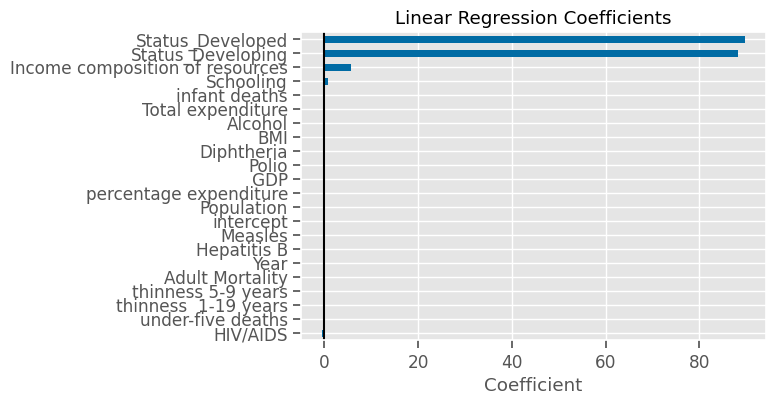

<AxesSubplot: title={'center': 'Linear Regression Coefficients'}, xlabel='Coefficient'>

In [13]:
## plot the coefficients
plot_coefficients(coeffs)

### Evaluating Our Random Forest

Split,R^2,MAE,RMSE
Train,0.99,0.45,0.71
Test,0.97,1.11,1.75


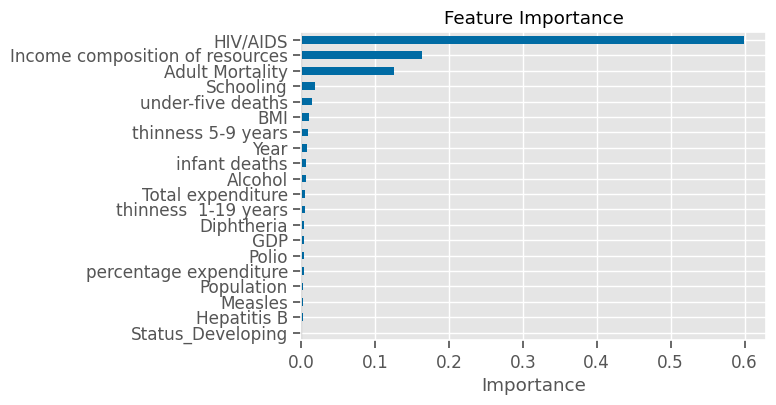

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [14]:
## evaluate the random forest
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

## extract the plot the feature importances
importances = get_importances(rf_reg)
plot_importances(importances)

## Permutation Importance

In [15]:
from sklearn.inspection import permutation_importance

### RandomForest Permutation Importance

>  Apply permutation importance to the random forest

In [16]:
## run performatation_importance on the rf  using the test data and random_state=SEED
result = permutation_importance(rf_reg, X_test_df, y_test,scoring='r2',
                                n_jobs=-1,random_state=SEED)
result.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [17]:
## save the average importances as a Series
perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)
perm_importances

Year                              0.01
Adult Mortality                   0.18
infant deaths                     0.01
Alcohol                           0.00
percentage expenditure            0.00
Hepatitis B                       0.00
Measles                           0.00
BMI                               0.01
under-five deaths                 0.01
Polio                             0.00
Total expenditure                 0.00
Diphtheria                        0.00
HIV/AIDS                          0.26
GDP                               0.00
Population                        0.00
thinness  1-19 years              0.00
thinness 5-9 years                0.01
Income composition of resources   0.15
Schooling                         0.01
Status_Developing                 0.00
dtype: float64

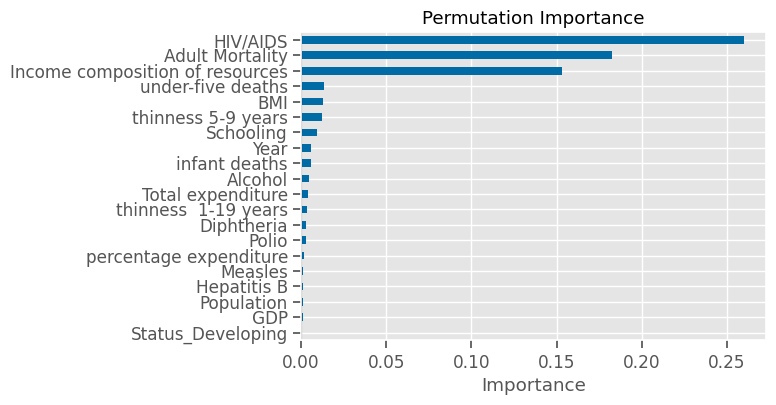

<AxesSubplot: title={'center': 'Permutation Importance'}, xlabel='Importance'>

In [18]:
# Use our plot_importances function, but change title to "Permutation Importance"
plot_importances(perm_importances,title='Permutation Importance')

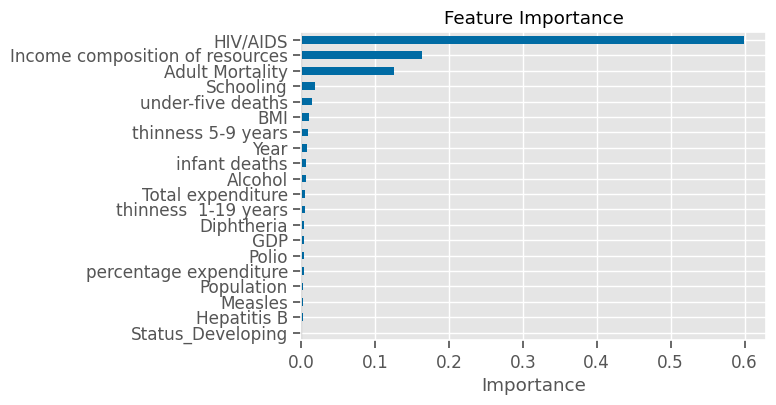

<AxesSubplot: title={'center': 'Feature Importance'}, xlabel='Importance'>

In [19]:
# Compare to the random forst feature importance
plot_importances(importances)

> Permutation Importance Can Be Applied to ANY Model!

### LinearRegression Permutation Importance

In [20]:
## run performatation_importance on the lin_reg  using the test data and random_state=SEED
results_linreg = permutation_importance(lin_reg, X_test_df, y_test,scoring='r2', n_repeats=3,
                                n_jobs=-1,random_state=SEED)
result.keys()

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names seen at fit time, yet now missing:
- Status_Developed

  warnings.warn(message, FutureWarning)


ValueError: X has 20 features, but LinearRegression is expecting 21 features as input.

In [ ]:
## Make into a series called perm_importances_linreg
perm_importances_linreg = pd.Series(result['importances_mean'], 
                                    index=lin_reg.feature_names_in_)

plot_importances(perm_importances_linreg)

In [ ]:
# final_plot_df = pd.concat([X_train_df, y_train], axis=1)
# corr = final_plot_df.corr()
# corr

In [ ]:
# corr['Life expectancy'].sort_values(ascending=False).to_frame().style.bar()

## Global Model Explanations

##  Applying Shap

In [21]:
# Import and init shap
import shap
shap.initjs()

In [22]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train_df,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
2301,"2,011.00",418.00,26.00,3.78,54.67,89.00,"1,865.00",22.20,38.00,88.00,11.98,89.00,1.30,445.52,"6,611,692.00",8.10,8.00,0.39,8.90,1.00
526,"2,001.00",54.00,17.00,1.52,33.65,81.44,"2,837.00",16.80,25.00,4.00,3.95,4.00,13.90,243.16,"383,223.00",1.40,1.40,0.31,5.30,1.00
2911,"2,010.00",363.00,30.00,2.47,184.36,83.00,"15,754.00",2.70,45.00,8.00,4.41,83.00,6.80,"1,463.21","138,533.00",6.70,6.50,0.53,11.80,1.00
2601,"2,015.00",152.00,2.00,4.58,0.00,76.00,43.00,17.40,2.00,75.00,5.93,76.00,0.10,"1,161.77","124,977.00",1.90,11.10,0.60,12.50,1.00
434,"2,013.00",412.00,59.00,3.15,0.00,8.00,48.00,26.80,81.00,79.00,5.81,8.00,2.40,"7,619.09","11,067,208.84",5.80,5.70,0.63,11.97,1.00


In [23]:
# Instantiate a Model Explainer with the model
explainer = shap.Explainer(rf_reg)

## Get shap values from the explainer
shap_values = explainer(X_shap,y_shap)

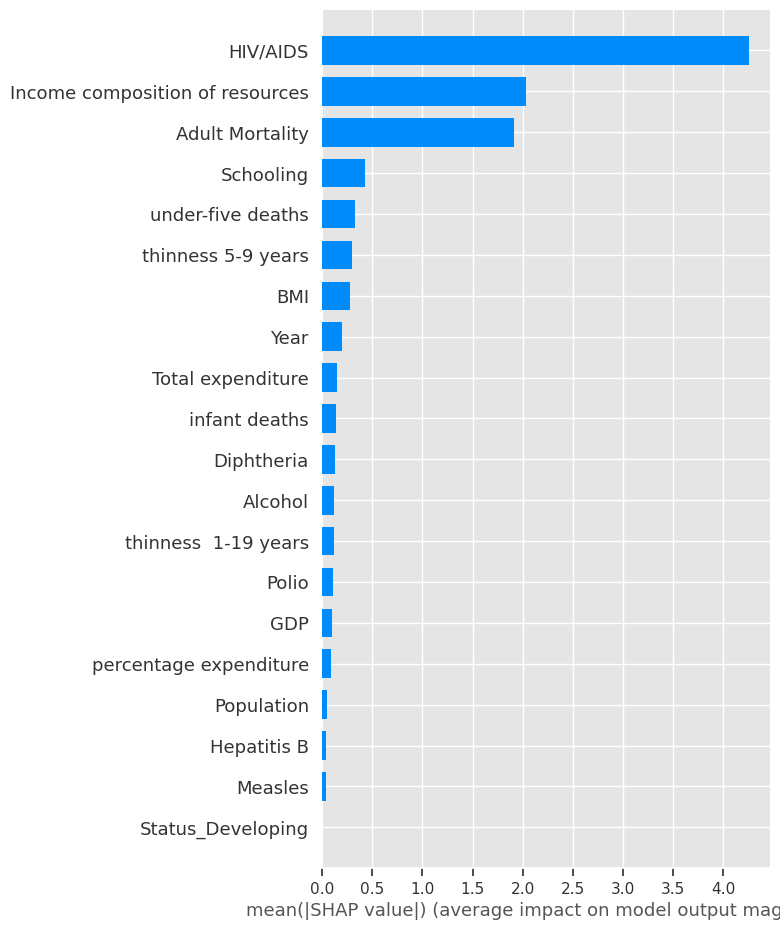

In [24]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


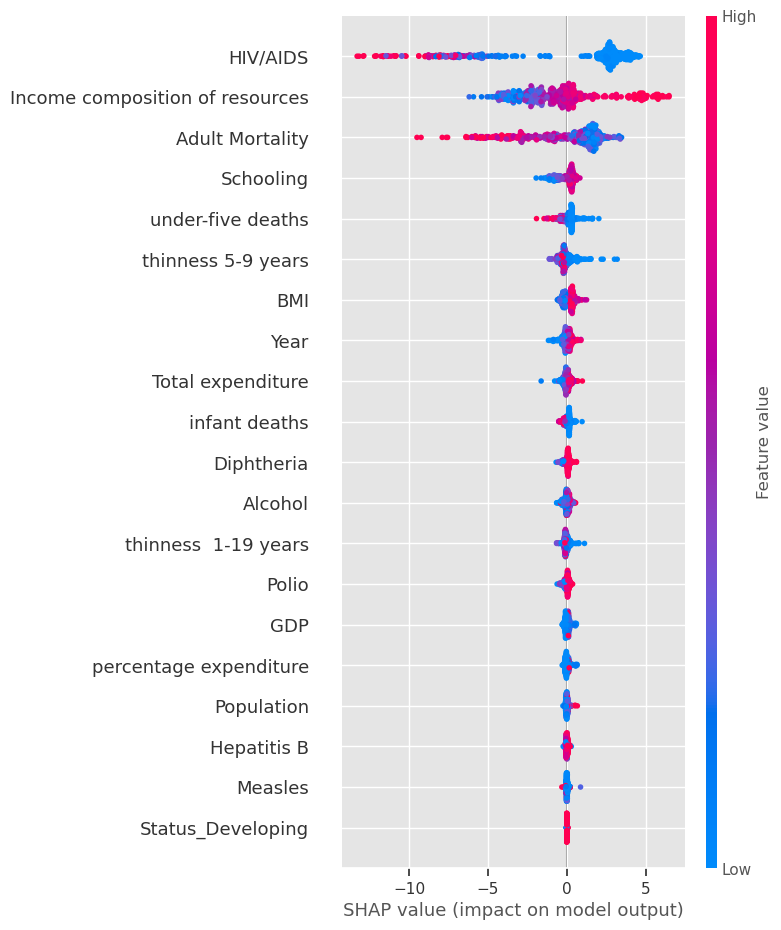

In [25]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)

In [26]:
## Create an explainer for the lin_reg
explainer_linreg = shap.Explainer(lin_reg, X_shap)

## get shap values for linreg
shap_values_linreg = explainer_linreg(X_shap)
shap_values_linreg.shape

ValueError: shapes (21,) and (20,) not aligned: 21 (dim 0) != 20 (dim 0)

In [27]:
## create a summary plot (bar version)
shap.summary_plot(shap_values_linreg, features = X_shap, plot_type='bar')

NameError: name 'shap_values_linreg' is not defined

In [28]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values_linreg, features = X_shap)

NameError: name 'shap_values_linreg' is not defined

> So why is our LinReg predicting a high life expectancy when infant deaths are high?

# Individual Explanations

In [29]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

,Year,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Status_Developing
0,"2,011.00",418.00,26.00,3.78,54.67,89.00,"1,865.00",22.20,38.00,88.00,11.98,89.00,1.30,445.52,"6,611,692.00",8.10,8.00,0.39,8.90,1.00
1,"2,001.00",54.00,17.00,1.52,33.65,81.44,"2,837.00",16.80,25.00,4.00,3.95,4.00,13.90,243.16,"383,223.00",1.40,1.40,0.31,5.30,1.00
2,"2,010.00",363.00,30.00,2.47,184.36,83.00,"15,754.00",2.70,45.00,8.00,4.41,83.00,6.80,"1,463.21","138,533.00",6.70,6.50,0.53,11.80,1.00
3,"2,015.00",152.00,2.00,4.58,0.00,76.00,43.00,17.40,2.00,75.00,5.93,76.00,0.10,"1,161.77","124,977.00",1.90,11.10,0.60,12.50,1.00
4,"2,013.00",412.00,59.00,3.15,0.00,8.00,48.00,26.80,81.00,79.00,5.81,8.00,2.40,"7,619.09","11,067,208.84",5.80,5.70,0.63,11.97,1.00


### Finding a Meaningful  Example to Explain

- Let's find the example with the most infant deaths.

In [30]:
# what is the max/range of infant deaths
X_shap_local['infant deaths'].describe()

count     500.00
mean       24.56
std        89.85
min         0.00
25%         0.00
50%         3.50
75%        22.00
max     1,700.00
Name: infant deaths, dtype: float64

In [31]:
## saving the index of the most deaths
idx_high_deaths = X_shap_local['infant deaths'].idxmax()
idx_high_deaths

449

In [32]:
# shap_values_linreg[2643]

In [33]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_deaths]

Year                                   2,003.00
Adult Mortality                          216.00
infant deaths                          1,700.00
Alcohol                                    1.19
percentage expenditure                    19.48
Hepatitis B                               81.44
Measles                               47,147.00
BMI                                       12.60
under-five deaths                      2,200.00
Polio                                     57.00
Total expenditure                          4.30
Diphtheria                                61.00
HIV/AIDS                                   0.30
GDP                                      541.14
Population                        11,827,848.00
thinness  1-19 years                      27.30
thinness 5-9 years                        28.30
Income composition of resources            0.51
Schooling                                  8.60
Status_Developing                          1.00
Name: 449, dtype: float64

In [34]:
## what was the actual life expectancy?
y_shap_local.iloc[idx_high_deaths]

63.7

## Shap Force Plots

### Force Plot - Linear Reg explanation

In [35]:
## plotting example force plot for most inf.deaths (from linreg)
shap.force_plot(explainer_linreg.expected_value, 
                shap_values=shap_values_linreg[idx_high_deaths].values,
               features=X_shap_local.iloc[idx_high_deaths])

NameError: name 'explainer_linreg' is not defined

### Force Plot - RandomForest explanation

In [36]:
## plotting example force plot for most inf.deaths (from rf)
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_high_deaths].values,
               features=X_shap_local.iloc[idx_high_deaths])

> ***Q: What do you notice when comparing the lin reg and rf reg force plots?***

### Additional Plots: Waterfall Plot

In [37]:
shap_values[idx_high_deaths]

.values =
array([-1.71154946e-01, -1.40495886e+00, -8.00032740e-02, -2.34683163e-02,
       -1.17086587e-01, -2.85912274e-02, -8.05120807e-02, -2.49052224e-01,
       -2.60109951e-01, -1.96725342e-01, -9.67105254e-02, -2.04495583e-01,
        2.89420647e+00, -1.11238119e-01,  1.83914659e-02, -9.61902302e-02,
       -1.93877453e-01, -3.96168467e+00, -9.49341788e-01,  6.21450163e-04])

.base_values =
array([69.19298179])

.data =
array([2.00300000e+03, 2.16000000e+02, 1.70000000e+03, 1.19000000e+00,
       1.94808682e+01, 8.14389292e+01, 4.71470000e+04, 1.26000000e+01,
       2.20000000e+03, 5.70000000e+01, 4.30000000e+00, 6.10000000e+01,
       3.00000000e-01, 5.41135228e+02, 1.18278480e+07, 2.73000000e+01,
       2.83000000e+01, 5.05000000e-01, 8.60000000e+00, 1.00000000e+00])

In [38]:
explanation = shap_values[idx_high_deaths]
explanation

.values =
array([-1.71154946e-01, -1.40495886e+00, -8.00032740e-02, -2.34683163e-02,
       -1.17086587e-01, -2.85912274e-02, -8.05120807e-02, -2.49052224e-01,
       -2.60109951e-01, -1.96725342e-01, -9.67105254e-02, -2.04495583e-01,
        2.89420647e+00, -1.11238119e-01,  1.83914659e-02, -9.61902302e-02,
       -1.93877453e-01, -3.96168467e+00, -9.49341788e-01,  6.21450163e-04])

.base_values =
array([69.19298179])

.data =
array([2.00300000e+03, 2.16000000e+02, 1.70000000e+03, 1.19000000e+00,
       1.94808682e+01, 8.14389292e+01, 4.71470000e+04, 1.26000000e+01,
       2.20000000e+03, 5.70000000e+01, 4.30000000e+00, 6.10000000e+01,
       3.00000000e-01, 5.41135228e+02, 1.18278480e+07, 2.73000000e+01,
       2.83000000e+01, 5.05000000e-01, 8.60000000e+00, 1.00000000e+00])

### Additional Plots: Decision Plot

In [39]:
# shap.decision_plot(explainer.expected_value, 
#                    shap_values.values[idx_high_deaths],
#                    X_shap_local.iloc[idx_high_deaths], 
#                    feature_names= list(X_shap_local.columns))

# LIME

In [40]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [41]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_high_deaths],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


# APPENDIX

In [42]:
def get_permutation_importance(rf_reg,X_test_df,y_test, scoring='r2',
                               n_repeats=3, n_jobs=-1,random_state=SEED):

    result = permutation_importance(rf_reg, X_test_df, y_test,scoring=scoring, 
                                    n_repeats=n_repeats, n_jobs=n_jobs,
                                    random_state=random_state)
    perm_importances = pd.Series(result['importances_mean'], index=rf_reg.feature_names_in_)
    return perm_importances

### Global Force Plots

In [ ]:
shap.force_plot(explainer_linreg.expected_value,shap_values.values,X_shap_local,)

In [ ]:
shap.force_plot(explainer.expected_value,shap_values.values,X_shap_local)